# 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')
plt.rc("axes", unicode_minus=False) # 음수값 깨지는 폰트 설정
pd.options.display.max_columns = 50 # 칼럼수 50개까지

In [24]:
# 평가산식
from sklearn.metrics import make_scorer

def nmae(answer, pred):
    mae = np.mean(np.abs(answer-pred))
    score = mae / np.mean(np.abs(answer))
    return score
NMAE = make_scorer(nmae, greater_is_better=False)

def at_NMAE(y_pred, dataset):
    y_true = dataset.get_label()
    
    mae = np.mean(np.abs(y_true-y_pred))
    score = mae / np.mean(np.abs(y_true))

    return "score", score, False

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")
train_data.shape, test_data.shape, submission.shape

((1015, 11), (436, 10), (436, 2))

In [26]:
train_data.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


In [27]:
train_data.describe()

,id,odometer,year,target
count,1015.000000,1015.000000,1015.000000,1.015000e+03
mean,507.000000,116842.121182,2008.385222,8.243204e+06
std,293.149564,105162.545836,35.592123,1.239567e+07
min,0.000000,0.000000,1217.000000,4.000000e+05
25%,253.500000,55918.000000,2006.000000,2.535000e+06
50%,507.000000,94972.000000,2010.000000,4.215000e+06
75%,760.500000,153224.000000,2014.000000,8.927500e+06
max,1014.000000,987322.000000,2020.000000,1.500150e+08


* id : 샘플 아이디
* title : 제조사 모델명
* odometer : 주행 거리
* location : 판매처(나이지리아 도시)
* isimported : 현지 사용 여부
* engine : 엔진 종류
* transmission : 트랜스미션 종류
* fuel : 연료 종류
* paint : 페인트 색상
* year : 제조년도
* target : 자동차 가격

# EDA

## target

[Text(0.5, 1.0, 'log_target 박스플롯')]

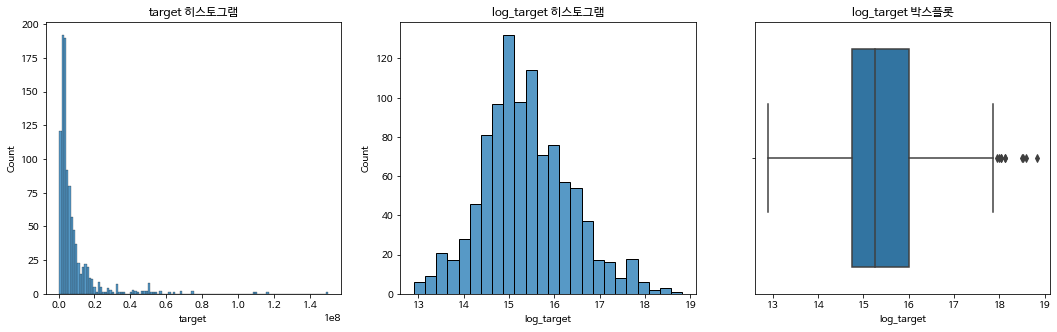

In [10]:
f , axes = plt.subplots(1,3)
axes = axes.flatten()
f.set_size_inches(18,5)

# target 의 log_scale
train_data["log_target"] = np.log(train_data["target"])

sns.histplot(x="target", data=train_data, ax=axes[0])
axes[0].set(title = "target 히스토그램")
sns.histplot(x="log_target", data=train_data, ax=axes[1])
axes[1].set(title = "log_target 히스토그램")
sns.boxplot(x="log_target", data=train_data, ax=axes[2])
axes[2].set(title = "log_target 박스플롯")

* 로그스케일 여부
* 이상치 제거 여부

## 차종별

In [ ]:
# 회사 이름
train_data["com"] = train_data["title"].map(lambda x: x.split()[0].upper())

In [7]:
def replacestring1(x):
    if x == "MERCEDES-BENZ/52":
        return "MERCEDES-BENZ"
    elif x== "MAN-VOLKSWAGEN":
        return "MAN"
    else:
        return x
    
def replacestringetc(data,x, counts):
    if sum(data == x) >counts:
        return x
    else:
        return "etc"

In [ ]:
train_data["com"] = train_data["com"].map(lambda x: replacestring1(x))
train_data["com"] = train_data["com"].map(lambda x: replacestringetc(train_data["com"], x, 5))

In [ ]:
train_data = train_data.drop(train_data[train_data["log_target"] > 17.875].index, axis=0) # 17.875 는 구간(25~75%) *1.5 + 75%

In [ ]:
f , axes = plt.subplots()
f.set_size_inches(10,6)
sns.barplot(x="com", y="log_target", data=train_data)

## 운행거리별

In [ ]:
f , axes = plt.subplots()
f.set_size_inches(10,6)
sns.barplot(x="odometer", y="target", data=train_data)

In [ ]:
# 주행거리가 0 인 값들은 새로운 피쳐 NEW -> O
train_data["old"] = train_data["odometer"].copy()
train_data["old"][train_data["old"]!=0] = 1
train_data["old"][train_data["old"]==0] = 0

In [ ]:
# 주행거리 0 인값들을 10으로 대체
train_data["odometer"][train_data["odometer"]==0]=10

# 주행거리 log
train_data["log_odometer"] = np.log(train_data["odometer"])

In [ ]:
# log_odometer 가 10 보다 크면 너무 오래된 것으로 1/0
train_data["too_old"] = train_data["log_odometer"].copy()
train_data["too_old"][train_data["too_old"]<10] = 0
train_data["too_old"][train_data["too_old"]>=10] = 1
train_data["too_old"] = train_data["too_old"].astype(int)

## location별

In [ ]:
train_data["location"].value_counts()

In [ ]:
# 5보다 작은 값은 etc
train_data["location"] = train_data["location"].map(lambda x: replacestringetc(train_data["location"],x,5))

In [ ]:
train_data["location"].value_counts()

In [ ]:
f , axes = plt.subplots()
f.set_size_inches(10,6)
sns.barplot(x="location", y="target", data=train_data)

## 사용경혐 별

In [ ]:
f , axes = plt.subplots()
f.set_size_inches(10,6)
sns.barplot(x="isimported", y="target", data=train_data)

## 엔진별

In [ ]:
train_data["engine_type"] = train_data["engine"].copy()
train_data["cylinder"] = train_data["engine"].copy()

train_data["cylinder"] = train_data["cylinder"].map(lambda x: x[-2])
train_data["engine_type"] = train_data["engine_type"].map(lambda x: x[-3])

In [ ]:
train_data["engine"].value_counts()

In [ ]:
f , axes = plt.subplots(1,2)
axes = axes.flatten()
f.set_size_inches(15,6)
sns.barplot(x="cylinder", y="target", data=train_data, ax=axes[0])
sns.barplot(x="engine_type", y="target", data=train_data, ax=axes[1])

## 변속기별

In [ ]:
train_data["transmission"].value_counts()

In [ ]:
f , axes = plt.subplots(1,2)
axes = axes.flatten()
f.set_size_inches(15,6)
sns.barplot(x="transmission", y="target", data=train_data, ax=axes[0])
sns.barplot(x="transmission", y="log_target", data=train_data, ax=axes[1])

* 피처 제거

## 연료별

In [ ]:
f , axes = plt.subplots(1,2)
axes = axes.flatten()
f.set_size_inches(15,6)
sns.barplot(x="fuel", y="target", data=train_data, ax=axes[0])
sns.barplot(x="fuel", y="log_target", data=train_data, ax=axes[1])

* 피처 제거

## 색깔별

In [4]:
train_data["paint"] = train_data["paint"].map(lambda x: x.upper())

In [5]:
train_data["paint"].unique()

array(['RED', 'BLACK', 'GRAY', 'WHITE', 'BLUE', 'REDL', 'SILVER',
       ' BLACK/RED', 'DEEP BLUE', 'DARK GREY', 'BROWN', 'GREY', 'GREEN',
       'PURPLE', 'GOLD', 'DARK BLUE', 'MILK', 'MIDNIGHT BLACK METAL',
       'BEIGE', 'BLUE ', 'SILVER ', 'DARK ASH', 'BLACK ', 'ORANGE',
       'CREAM', 'DARK GRAY', 'SLIVER', 'WHITE ORCHILD PEARL',
       'DARK GREEN', 'GOLD ', 'YELLOW', 'GREY ', 'LIGHT GOLD', 'WHITE ',
       'WINE', 'WHITE-BLUE', 'MAGNETIC GRAY', 'GRAY ', 'DARK SILVER ',
       'DARK BLUE ', 'BLACK.', 'SILVER/GREY', 'INK BLUE', 'LIGHT BLUE',
       'SKY BLUE', 'GERY', 'PALE BROWN', 'WHINE ', 'CREAM ',
       'BLACK AND SILVER', 'LIGHT SILVER ', 'BLACK SAND PEARL',
       'OFF WHITE', 'ASH', 'MAROON', 'NAVY BLUE', 'SUPER WHITE', ' BLACK',
       'ASH AND BLACK', 'GREEN ', 'MAGNETIC GRAY METALLIC', 'SKYE BLUE',
       'OFF WHITE L'], dtype=object)

In [8]:
train_data["color"] = train_data["paint"].copy()
train_data["color"] = train_data["color"].map(lambda x: x.split()[-1]).map(lambda x:x[0])
train_data["color"] = train_data["color"].map(lambda x: replacestringetc(train_data["color"], x, 5))

<AxesSubplot:xlabel='color', ylabel='log_target'>

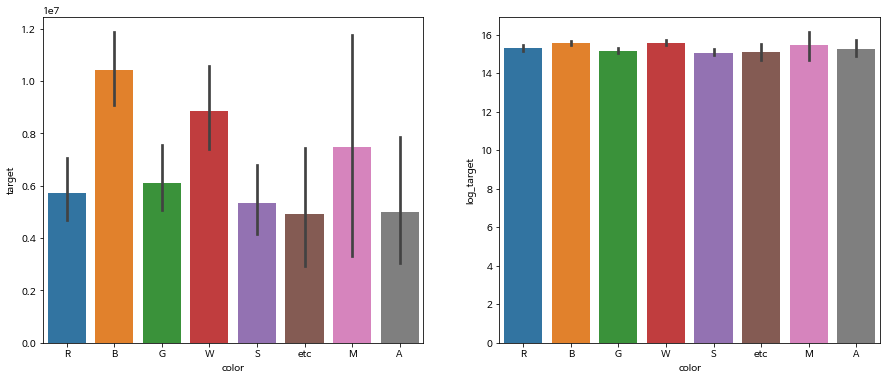

In [11]:
f , axes = plt.subplots(1,2)
axes = axes.flatten()
f.set_size_inches(15,6)
sns.barplot(x="color", y="target", data=train_data, ax=axes[0])
sns.barplot(x="color", y="log_target", data=train_data, ax=axes[1])

In [8]:
def twocolorcheck(x):
    if len(x.split())>1:
        return 1
    elif len(x.split("/"))>1:
        return 1
    else:
        return 0

In [9]:
train_data["2color"] = train_data["paint"].copy()
train_data["2color"] = train_data["2color"].map(lambda x: twocolorcheck(x))

ValueError: Could not interpret input 'log_target'

findfont: Font family ['Noto Sans KR'] not found. Falling back to DejaVu Sans.


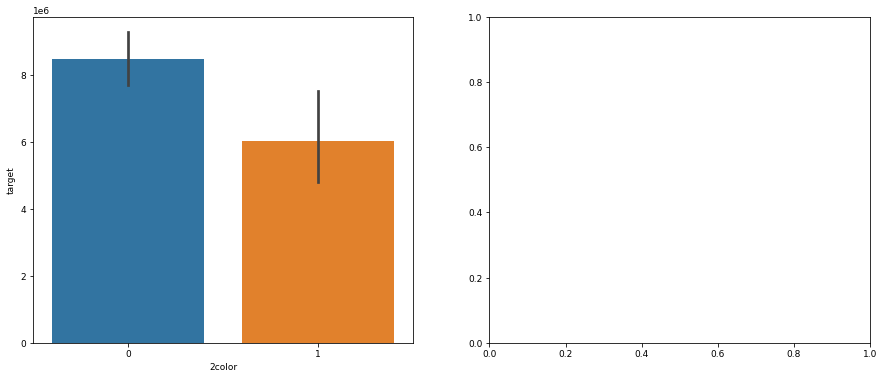

In [10]:
f , axes = plt.subplots(1,2)
axes = axes.flatten()
f.set_size_inches(15,6)
sns.barplot(x="2color", y="target", data=train_data, ax=axes[0])
sns.barplot(x="2color", y="log_target", data=train_data, ax=axes[1])

## 연도별

In [ ]:
f , axes = plt.subplots(1,3)
axes = axes.flatten()
f.set_size_inches(15,6)
sns.barplot(x="year", y="target", data=train_data, ax=axes[0])
sns.barplot(x="year", y="log_target", data=train_data, ax=axes[1])
sns.boxplot(x="year", data=train_data, ax=axes[2])

In [ ]:
train_data["year"].value_counts()

In [34]:
def yearchange(x):
    if x >= 1990 and x<2000:
        return 1990
    elif x >= 1980 and x<1990:
        return 1980
    elif x<1900:
        return 1900
    else:
        return x

In [ ]:
train_data["year"] = train_data["year"].map(lambda x: yearchange(x))

In [35]:
def antic(x):
    if x > 1950:
        return 0
    if x <= 1950:
        return 1
train_data["antic"] = train_data["year"].copy()
train_data["antic"] = train_data["antic"].map(lambda x: antic(x))

# 베이스 라인 모델

In [63]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv")
all_data = pd.concat([train_data, test_data], ignore_index=True)

In [64]:
all_data.tail(5)

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
1446,431,Mercedes-Benz GLK 350,78175,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Dark Blue,2014,NaN
1447,432,Honda Crosstour,129223,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2011,NaN
1448,433,Mercedes-Benz ML 350,100943,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black,2013,NaN
1449,434,Lexus GX 470,81463,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Mint green,2003,NaN
1450,435,Toyota Sienna,646,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Silver,2006,NaN


In [65]:
all_data["log_target"] = np.log(all_data["target"])
all_data["com"] = all_data["title"].map(lambda x: x.split()[0].upper())
all_data["com"] = all_data["com"].map(lambda x: replacestring1(x))
all_data["com"] = all_data["com"].map(lambda x: replacestringetc(all_data["com"], x, 5))
all_data = all_data.drop(all_data[all_data["log_target"] > 17.875].index, axis=0) # 17.875 는 구간(25~75%) *1.5 + 75%
all_data["old"] = all_data["odometer"].copy()
all_data["old"][all_data["old"]!=0] = 1
all_data["old"][all_data["old"]==0] = 0
all_data["odometer"][all_data["odometer"]==0]=10
all_data["log_odometer"] = np.log(all_data["odometer"])
all_data["too_old"] = all_data["log_odometer"].copy()
all_data["too_old"][all_data["too_old"]<10] = 0
all_data["too_old"][all_data["too_old"]>=10] = 1
all_data["too_old"] = all_data["too_old"].astype(int)
all_data["location"] = all_data["location"].map(lambda x: replacestringetc(all_data["location"],x,5))
all_data["paint"] = all_data["paint"].map(lambda x: x.upper())
all_data["color"] = all_data["paint"].copy()
all_data["color"] = all_data["color"].map(lambda x: x.split()[-1]).map(lambda x:x[0])
all_data["color"] = all_data["color"].map(lambda x: replacestringetc(all_data["color"], x, 10))
all_data["2color"] = all_data["paint"].copy()
all_data["2color"] = all_data["2color"].map(lambda x: twocolorcheck(x))
all_data["year"] = all_data["year"].map(lambda x: yearchange(x))
all_data["antic"] = all_data["year"].copy()
all_data["antic"] = all_data["antic"].map(lambda x: antic(x))
all_data["engine_type"] = all_data["engine"].copy()
all_data["cylinder"] = all_data["engine"].copy()
all_data["cylinder"] = all_data["cylinder"].map(lambda x: x[-2])
all_data["engine_type"] = all_data["engine_type"].map(lambda x: x[-3])

In [49]:
# 제거할 피쳐 : 연료별, 변속기별
drop_feature = ["title","id", "odometer","transmission","fuel","target","paint","engine"]
nom_feature = ["location", "isimported","engine_type","com","color","year","cylinder"]
bin_feature = ["too_old","old","2color","antic"]

## 연속형 변수

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
all_data["log_odometer"] = scaler.fit_transform(all_data[["log_odometer"]])

In [66]:
all_data

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,...,log_target,com,old,log_odometer,too_old,color,2color,antic,engine_type,cylinder
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,RED,2016,...,16.430348,TOYOTA,1,9.813399,0,R,0,0,I,4
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,BLACK,2019,...,17.312473,TOYOTA,1,2.302585,0,B,0,0,I,4
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,RED,2012,...,16.109559,LAND,1,11.327692,1,R,0,0,V,6
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,GRAY,2007,...,15.154451,LEXUS,1,11.424357,1,G,0,0,I,4
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,RED,2010,...,15.814961,TOYOTA,1,11.452931,1,R,0,0,V,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,431,Mercedes-Benz GLK 350,78175,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,DARK BLUE,2014,...,NaN,MERCEDES-BENZ,1,11.266705,1,B,1,0,V,6
1447,432,Honda Crosstour,129223,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,RED,2011,...,NaN,HONDA,1,11.769295,1,R,0,0,V,6
1448,433,Mercedes-Benz ML 350,100943,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,BLACK,2013,...,NaN,MERCEDES-BENZ,1,11.522311,1,B,0,0,I,4
1449,434,Lexus GX 470,81463,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,MINT GREEN,2003,...,NaN,LEXUS,1,11.307904,1,G,1,0,I,4


## 명목형 변수

In [52]:
from sklearn.preprocessing import OneHotEncoder

encoder =OneHotEncoder()
encoded_nom_matrix = encoder.fit_transform(all_data[nom_feature])
encoded_nom_matrix

<1441x71 sparse matrix of type '<class 'numpy.float64'>'
	with 10087 stored elements in Compressed Sparse Row format>

In [53]:
all_data = all_data.drop(nom_feature, axis=1)
all_data = all_data.drop(drop_feature, axis=1)

In [54]:
all_data

,log_target,old,log_odometer,too_old,2color,antic
0,16.430348,1,0.621393,0,0,0
1,17.312473,1,0.000000,0,0,0
2,16.109559,1,0.746675,1,0,0
3,15.154451,1,0.754673,1,0,0
4,15.814961,1,0.757037,1,0,0
...,...,...,...,...,...,...
1446,NaN,1,0.741630,1,1,0
1447,NaN,1,0.783210,1,0,0
1448,NaN,1,0.762777,1,0,0
1449,NaN,1,0.745038,1,1,0


## 합치기

In [58]:
from scipy import sparse
from pycaret.regression import *

In [59]:
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data),
                              encoded_nom_matrix], format="csr")

In [61]:
data = setup(data=all_data, target="log_target", train_size=0.8)

,Description,Value
0,session_id,7777
1,Target,log_target
2,Original Data,"(1441, 6)"
3,Missing Values,True
4,Numeric Features,2
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(791, 5)"


In [62]:
blender = blend_models(estimator_list=compare_models(n_select=3, sort="NMAE"))

ValueError: Sort method not supported. See docstring for list of available parameters.